# Project 2: Multilayer Perceptron

Luke Ehrisman, Ben Williams

a. Load and preprocess the dataset
b. Train and test MLP model on dataset while tunning parameters to develop
multiple candidates
c. Evaluate models using appropriate metrics
d. Select most promising model
e. Predict response variable for validation inputs by using most promising moddel

In [3]:
import pandas as pd
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

a. Load and preprocess the dataset

In [447]:
# import preprocessed datasets (from Project 1)
df = pd.read_csv("data/processed_adult_data.csv")
df_valid = pd.read_csv("data/processed_validation_inputs.csv")

# assign features and target
X = df.drop('income', axis=1).values
y = df['income'].values

# encode target to integers (e.g. 0/1)
le = LabelEncoder()
y = le.fit_transform(y)

# scale features for stability
scaler = StandardScaler()
X = scaler.fit_transform(X)

# # test/train split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y)

# create train, test, and validation datasets
# modified book code to use traditional use of train, test, and validation
#    means switched naming schemes of test and validation from original code

X_temp, X_valid, y_temp, y_valid = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

b. Train and test MLP model on dataset while tunning parameters to develop
multiple candidates

In [448]:
# In Class: this is what author uses to create "model"
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

# create model of the class NeuralNetMLP
# model = NeuralNetMLP(num_features=28*28,
#                      num_hidden=50,
#                      num_classes=10)

num_classes = len(np.unique(y_train))
model = NeuralNetMLP(num_features=X_train.shape[1],
                     num_hidden=50,
                     num_classes=num_classes)

In [449]:
# create function that computes MSE and accuracy based on the full batch
def compute_mse_and_acc(nnet, X, y, num_labels=2):
    mse, correct_pred, num_examples = 0., 0, 0

    _, probas = nnet.forward(X)
    predicted_labels = np.argmax(probas, axis=1)

    onehot_targets = int_to_onehot(y, num_labels=num_labels)
    loss = np.mean((onehot_targets - probas)**2)
    correct_pred += (predicted_labels == y).sum()

    num_examples += y.shape[0]
    mse += loss

    acc = correct_pred/num_examples
    return mse, acc

In [450]:
# compute the MSE and ACC based on the model for the validation dataset
# this provides a pre training evaluation of the model of test before training
mse, acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Initial test MSE: {mse:.1f}')
print(f'Initial test accuracy: {acc*100:.1f}%')

Initial test MSE: 0.2
Initial test accuracy: 70.3%


In [451]:
# function to train "model" based on the training and test data to find weights that improves performance
def train(model, X_train, y_train, X_test, y_test, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_test_acc = []

    for e in range(num_epochs):

        #### Compute outputs ####
        a_h, a_out = model.forward(X_train)

        #### Compute gradients ####
        d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
            model.backward(X_train, a_h, a_out, y_train)

        #### Update weights ####
        model.weight_h -= learning_rate * d_loss__d_w_h
        model.bias_h -= learning_rate * d_loss__d_b_h
        model.weight_out -= learning_rate * d_loss__d_w_out
        model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
        train_acc, test_acc = train_acc*100, test_acc*100
        epoch_train_acc.append(train_acc)
        epoch_test_acc.append(test_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_test_acc

In [458]:
# performing training of "model" on training and test data
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_test_acc = train(
    model, X_train, y_train, X_test, y_test,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.17 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 002/050 | Train MSE: 0.17 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 003/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 004/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 005/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 006/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 007/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 008/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 009/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 010/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 011/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 012/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 013/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc: 75.92%
Epoch: 014/050 | Train MSE: 0.16 | Train Acc: 75.93% | Test Acc:

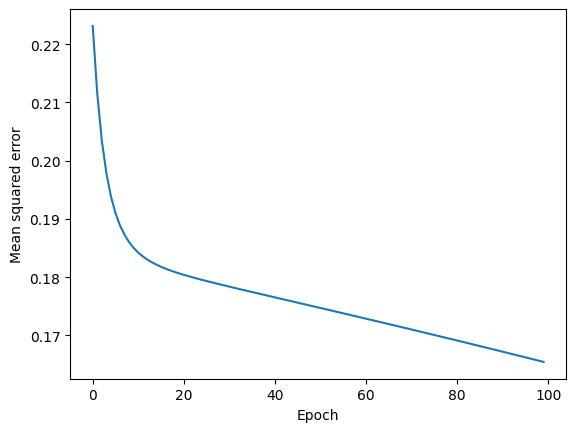

In [453]:
# evaluate MLP with minibatch performance
# plot Epoch vs MSE
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

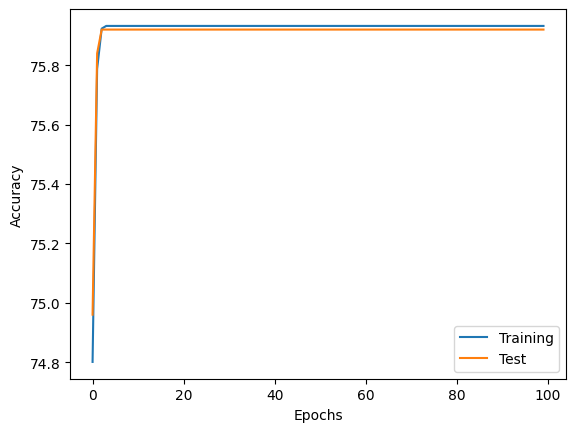

In [454]:
# plot Epoch vs accuracy for training and validation test
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_test_acc)), epoch_test_acc,
         label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [455]:
# look at the accuracy of the validation dataset (i.e., new data)
valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Validation accuracy: {valid_acc*100:.2f}%')

Validation accuracy: 75.93%


c. Evaluate models using appropriate metrics

d. Select most promising model

e. Predict response variable for validation inputs by using most promising model

In [456]:
# Compute predicted probabilities and labels
_, probas = model.forward(X_test)
predicted_labels = np.argmax(probas, axis=1)

# for LabelEncoder earlier, inverse transform:
predicted_income = le.inverse_transform(predicted_labels)

pred_df = pd.DataFrame({
    'Predicted_Income': predicted_income,
    'Actual_Income': le.inverse_transform(y_test),
    'isFail': y_test
})

# Save to CSV
pred_df.to_csv("predictions/adult_income_predictions.csv", index=False)
print("Predictions saved to 'adult_income_predictions.csv'")

Predictions saved to 'adult_income_predictions.csv'


In [457]:
num_correct = (pred_df['Predicted_Income'] == pred_df['Actual_Income']).sum()
num_total = len(pred_df)
print(f"Correct: {num_correct}/{num_total} ({num_correct / num_total * 100:.2f}%)")

Correct: 3796/5000 (75.92%)


# Reflection and Conceptual Questions

A) Why did you choose the specific architecture (e.g., number of layers, activation functions) for each model?

B) How did you monitor and mitigate overfitting in your models?

C) What ethical concerns might arise from deploying models trained on these datasets?

Firstly, this dataset includes many sensitive attributes like sex, race, and marital status. If this model is trained freely, it may reproduce social biases. Other proxy variables, such as occupation or education, could also have the same reprocussions.

If the model is trained with these biases, then it could lead to real-world impacts on people's lives. If this model were to be used for employment screening, lending, insurance, or government policies, it oculd lead to severe systemic discrimination.

Finally, the model only represents a small portion of people. As seen below, the counts of race or sex are heavily skewed. If this dataset were to be used on other demographics or populations, it could cause unintended problems.

In [12]:
#Count total values in 'race' and 'sex' column in original csv
print(pd.read_csv("data/project_adult.csv")['race'].value_counts())
print("\n", pd.read_csv("data/project_adult.csv")['sex'].value_counts())


race
White                 22221
Black                  2525
Asian-Pac-Islander      846
Amer-Indian-Eskimo      240
Other                   216
Name: count, dtype: int64

 sex
Male      17403
Female     8645
Name: count, dtype: int64


D) Why are activation functions necessary in Neural Networks?

Activation functions are necessary mainly because they introduce nonlinearity into the network. Without a activation function, a neural network will always apply a linear transformation upon the data. However, when adding something like a ReLU  or Sigmoid, the model can be used to represent complex relationships. 

The other main function that activation functions have is converting outputs into usable forms. When the network finishes, it outputs random numbers based on its findings. When you apply an activation function to them, it turns them into something usable, like probabilities.